# Model Exploration

## Table of Contents
1. [Imports](#imports)
2. [Import_Data](#importData)
    1. [GVB_Data](#GVBData)
    2. [Amsterdam_Event_Data](#EventData)
    3. [Crowdedness_Data](#CrowdData)
3. [Data_Preperation](#DataPrep)
    1. [Combine_Datasets](#CombData)
    2. [Construct_Model_DataFrame](#testModel)
4. [Regression_Models](#regModels)
    1. [Split_Train_and_Test_Data](#trainTestSplit)
    2. [Baseline](#regBaseModel)
    3. [Random_Forrest_Regressor](#regRFGModel)
    4. [Gradient_Boosting_Regressor](#regGBRModel)
    5. [Lasso](#regABRModel)
5. [Classification_Models](#classification)
    1. [Numerical_Labels_to_Categorical_Labels](#classCatVar)
    2. [Split_Train_and Test_Data](#classTrainSplit)
    3. [Baseline](#classBaseModel)
    4. [Random_Forrest_Classifier](#classRFCModel)
    5. [Gradient_Boosting_Classification](#classGBCModel)
    6. [SGD](#classSGDModel)
    7. [Voting_Classification](#classVCModel)

## Imports <a name="imports"></a>

In [31]:
#Train/Test section
from sklearn.model_selection import train_test_split

#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

import datetime

## Import Data <a name="importData"></a>

### Crowdedness Data <a name="CrowdData"></a>

In [143]:
#Full Crowdedness Dataset
crowd_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Crowdedness.csv")

In [144]:
#Convert DF to Dict
crowd_dict = crowd_df.to_dict("index")

#Transform date from string to datetime object
for k, v in crowd_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
crowd_df = pd.DataFrame.from_dict(crowd_dict, orient="index")

In [145]:
crowd_df = crowd_df.sort_values(by=["Date"]).reset_index().drop(columns=["index"])

In [146]:
# Start data
start_date = crowd_df.min().Date

# End date
end_date = crowd_df.max().Date

In [98]:
crowd_df.head()

,Sensor,Date,Hour,SensorLongitude,SensorLatitude,CrowdednessCount
0,GAWW-02,2018-03-11,0,4.898903,52.373786,0
1,GAWW-02,2018-03-11,400,4.898903,52.373786,0
2,GAWW-02,2018-03-11,1200,4.898903,52.373786,0
3,GAWW-02,2018-03-11,300,4.898903,52.373786,0
4,GAWW-02,2018-03-11,1000,4.898903,52.373786,0


### Amsterdam Event Data <a name="EventData"></a>
Import Amsterdam Event Data

In [148]:
#Full Events Dataset
events_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Events.csv")

In [149]:
#Convert DF to Dict
events_dict = events_df.to_dict("index")

#Transform date from string to datetime object
for k, v in events_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
events_df = pd.DataFrame.from_dict(events_dict, orient="index")

In [150]:
events_df = events_df[(events_df["Date"] > start_date) & (events_df["Date"] < end_date)].reset_index().drop(columns=["index"])

In [151]:
events_df.head()

,Date,Event,Latitude,Longtitude
0,2018-04-20,Springsnow Festival,52.372638,4.894106
1,2018-05-20,Springsnow Festival,52.372638,4.894106
2,2018-06-02,Holland Festival,52.361582,4.885479
3,2018-06-03,Holland Festival,52.361582,4.885479
4,2018-06-04,Holland Festival,52.361582,4.885479


### GVB Data <a name="GVBData"></a>
Import the GVB data and convert the Date column to [Pandas Timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html). Aftwerwards the dataset is split into the following two sets:
- Training: All data before the given *series_date*
    - Used for training and validating the model
- Series: All data before the given *series_date*
    - Used to construct a Time Series

In [152]:
#Full GVB Dataset
gvb_df = pd.read_csv("../../../Data_thesis/Full_Datasets/GVB.csv")

In [153]:
#Convert DF to Dict
gvb_dict = gvb_df.to_dict("index")

#Transform date from string to datetime object
for k, v in gvb_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
gvb_df = pd.DataFrame.from_dict(gvb_dict, orient="index")

In [154]:
gvb_df = gvb_df[(gvb_df["Date"] > start_date) & (gvb_df["Date"] < end_date)].reset_index().drop(columns=["index"])

In [155]:
#Contents
gvb_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,2018-04-01,0,NMT,52.371942,4.901239,31.0,115.0,5069,52.376288,4.893731,...,4.89008,43.0,254.0,5062,52.369097,4.889259,0.0,46.0,6,1
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069,52.376288,4.893731,...,4.89008,129.0,0.0,5062,52.369097,4.889259,11.0,0.0,6,1
2,2018-04-01,700,NMT,52.371942,4.901239,99.0,120.0,5069,52.376288,4.893731,...,4.89008,174.0,57.0,5062,52.369097,4.889259,54.0,17.0,6,1
3,2018-04-01,800,NMT,52.371942,4.901239,222.0,236.0,5069,52.376288,4.893731,...,4.89008,491.0,111.0,5062,52.369097,4.889259,139.0,64.0,6,1
4,2018-04-01,900,NMT,52.371942,4.901239,269.0,169.0,5069,52.376288,4.893731,...,4.89008,764.0,151.0,5062,52.369097,4.889259,215.0,61.0,6,1


## Data Preperation <a name="DataPrep"></a>

### Combine datasets <a name="CombData"></a>

In [156]:
gvb_crowd_df = pd.merge(gvb_df, crowd_df, on=["Date", "Hour"], how="outer")

In [157]:
gvb_crowd_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount
0,2018-04-01,0,NMT,52.371942,4.901239,31.0,115.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,0.0,46.0,6.0,1.0,GAWW-02,4.898903,52.373786,3813
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,11.0,0.0,6.0,1.0,GAWW-02,4.898903,52.373786,105
2,2018-04-01,700,NMT,52.371942,4.901239,99.0,120.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,54.0,17.0,6.0,1.0,GAWW-02,4.898903,52.373786,72
3,2018-04-01,800,NMT,52.371942,4.901239,222.0,236.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,139.0,64.0,6.0,1.0,GAWW-02,4.898903,52.373786,71
4,2018-04-01,900,NMT,52.371942,4.901239,269.0,169.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,215.0,61.0,6.0,1.0,GAWW-02,4.898903,52.373786,187


In [158]:
full = pd.merge(gvb_crowd_df, events_df, on=["Date"], how="outer")
full = full.rename(index=str, columns={"Latitude": "event_lat", "Longtitude": "event_lon", "Event": "is_event"})
full = full.fillna(0.0)

In [159]:
full_dict = full.to_dict("index")

for k, v in full_dict.items():
    if v["is_event"] != 0.0:
        v["is_event"] = 1.0
    
    if v["Hour"] == 0:
        v["Hour"] = 2400

full = pd.DataFrame.from_dict(full_dict, orient="index").reset_index().drop(columns=["index"])

### Make Time circular

In [163]:
full = full.assign(Year=0, month_sin=0, month_cos=0, day_sin=0, day_cos=0, hour_sin=0, hour_cos=0)

In [164]:
full.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,is_event,event_lat,event_lon,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2018-04-01,2400,NMT,52.371942,4.901239,31.0,115.0,5069.0,52.376288,4.893731,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069.0,52.376288,4.893731,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,2018-04-01,1500,NMT,52.371942,4.901239,362.0,407.0,5069.0,52.376288,4.893731,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,2018-07-01,800,NMT,52.371942,4.901239,90.0,40.0,5069.0,52.376288,4.893731,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,2018-08-03,1300,NMT,52.371942,4.901239,360.0,210.0,5069.0,52.376288,4.893731,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [165]:
time_dict = full.to_dict("index")

for k, v in time_dict.items():    
    v["Year"] = v["Date"].year
    
    v["month_sin"] = np.sin(2 * np.pi * v["Date"].month / 12)
    v["month_cos"] = np.cos(2 * np.pi * v["Date"].month / 12)
    
    v["day_sin"] = np.sin(2 * np.pi * v["Date"].day / 365)
    v["day_cos"] = np.cos(2 * np.pi * v["Date"].day / 365)

    v["hour_sin"] = np.sin(2 * np.pi * v["Hour"] / 2400)
    v["hour_cos"] = np.cos(2 * np.pi * v["Hour"] / 2400)
    
full = pd.DataFrame.from_dict(time_dict, orient="index").reset_index()

In [187]:
cols = ["Date",'is_event', 'event_lat', 'event_lon', 'NieuwmarktLat', 'NieuwmarktLon', 
        'NieuwmarktArrivals', 'NieuwmarktDepartures', 'NieuwezijdsLat', 'NieuwezijdsLon', 
        'NieuwezijdsArrivals', 'NieuwezijdsDepartures', 'DamLat', 'DamLon', 'DamArrivals', 
        'DamDepartures', 'SpuiLat', 'SpuiLon', 'SpuiArrivals', 'SpuiDepartures', 'weekday', 'is_weekend',
        'SensorLongitude', 'SensorLatitude', 'Year', 'month_sin', 'month_cos', 
        'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'CrowdednessCount']

full = full[cols]

In [188]:
full.head()

,Date,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,NieuwezijdsLon,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2019-03-26,0.0,0.0,0.0,52.371942,4.901239,31.0,115.0,52.376288,4.893731,...,4.898903,52.373786,2018,0.866025,-0.500000,0.017213,0.999852,-2.449294e-16,1.000000e+00,3813
1,2019-03-16,0.0,0.0,0.0,52.371942,4.901239,67.0,50.0,52.376288,4.893731,...,4.898903,52.373786,2018,0.866025,-0.500000,0.017213,0.999852,1.000000e+00,6.123234e-17,105
2,2018-09-16,0.0,0.0,0.0,52.371942,4.901239,362.0,407.0,52.376288,4.893731,...,4.898903,52.373786,2018,0.866025,-0.500000,0.017213,0.999852,-7.071068e-01,-7.071068e-01,3669
3,2019-03-19,0.0,0.0,0.0,52.371942,4.901239,90.0,40.0,52.376288,4.893731,...,4.897334,52.372524,2018,-0.500000,-0.866025,0.017213,0.999852,8.660254e-01,-5.000000e-01,79
4,2018-12-13,0.0,0.0,0.0,52.371942,4.901239,360.0,210.0,52.376288,4.893731,...,4.898903,52.373786,2018,-0.866025,-0.500000,0.051620,0.998667,-2.588190e-01,-9.659258e-01,1465


### Visualization

In [189]:
x = full.drop(["CrowdednessCount", "Date", ], axis=1)
y = full["CrowdednessCount"]

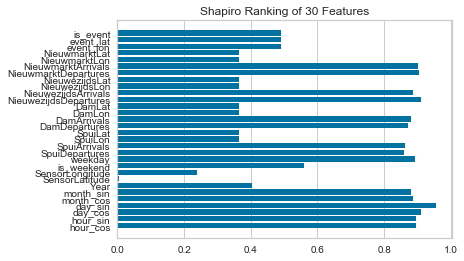

In [190]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

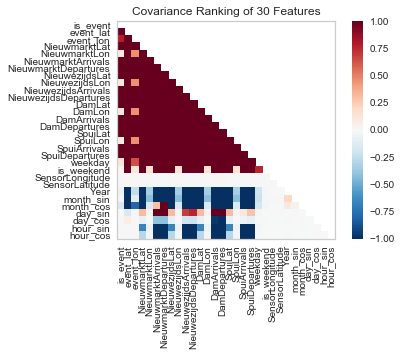

In [191]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

### Split Data into Training/Test and Time Series data

In [375]:
split_date = pd.Timestamp(2018, 12, 31)

TrainTest_df = full[full["Date"] <= split_date].reset_index().drop(columns=["index"])
TimeSeries_df = full[full["Date"] > split_date].reset_index().drop(columns=["index"])

### Criteria for train and test Model <a name="testModel"></a>
Based on the dates.

In [382]:
all_dates = TrainTest_df["Date"].values
np.random.shuffle(all_dates)

In [383]:
split_dates = int(all_dates.size * 0.9)
train_set_dates = all_dates[:split_dates]
test_set_dates = all_dates[split_dates:]

## Regression Models <a name="regModels"></a>

### Train and Test split

In [387]:
train_df_reg = TrainTest_df[TrainTest_df["Date"].isin(train_set_dates)].drop(columns=["Date"])

test_df_reg = TrainTest_df[TrainTest_df["Date"].isin(test_set_dates)].drop(columns=["Date"])

In [389]:
#Train
x_train_reg = train_df_reg.drop(["CrowdednessCount"], axis=1)
y_train_reg = train_df_reg["CrowdednessCount"]

#Test
x_test_reg = test_df_reg.drop(["CrowdednessCount"], axis=1)
y_test_reg = test_df_reg["CrowdednessCount"]

feature_labels_reg = train_df_reg.columns.values

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [390]:
#Give parameters model
reg_base = LinearRegression(n_jobs=5)

In [391]:
#Fit the model
reg_base.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=5, normalize=False)

In [392]:
reg_base_score = reg_base.score(x_test_reg, y_test_reg)

y_pred_lr = reg_base.predict(x_test_reg)
reg_mse = mean_squared_error(y_pred_lr, y_test_reg)

print("R^2 Score: ", reg_base_score)
print("MSE: ", reg_mse)
print("RMSE: ", np.sqrt(reg_mse))

R^2 Score:  0.709222215102792
MSE:  460899.2076033961
RMSE:  678.8955793075958


In [393]:
for i in range(10):
    print("Predicted: ", y_pred_lr[i], "Real: ", y_test_reg[i])

Predicted:  3522.7289746664464 Real:  3669
Predicted:  1583.6155726127326 Real:  1465
Predicted:  1448.8860514424741 Real:  1935
Predicted:  1735.4896481595933 Real:  2383
Predicted:  1742.6929288301617 Real:  1541
Predicted:  2338.3508766032755 Real:  2360
Predicted:  2013.4366323128343 Real:  1536
Predicted:  2609.094580085948 Real:  2402
Predicted:  1985.7733542323112 Real:  1409
Predicted:  2581.431302005425 Real:  2559


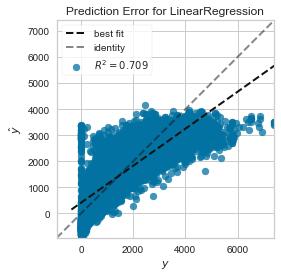

In [394]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

In [395]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True)

In [396]:
#fit the model
reg_rfg.fit(x_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=100,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [397]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test_reg, y_test_reg)

#Test
y_pred_rfg = reg_rfg.predict(x_test_reg)
reg_rfg_mse = mean_squared_error(y_pred_rfg, y_test_reg)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

R^2 Score:  0.9885738280028835
MSE Test:  18111.127785338816
RMSE Test:  134.57759020482874


In [398]:
for i in range(10):
    print("Predicted: ", y_pred_rfg[i], "Real: ", y_test_reg[i])

Predicted:  3605.564 Real:  3669
Predicted:  1541.266 Real:  1465
Predicted:  1867.828 Real:  1935
Predicted:  2332.76 Real:  2383
Predicted:  1572.692 Real:  1541
Predicted:  2393.896 Real:  2360
Predicted:  1427.286 Real:  1536
Predicted:  2337.834 Real:  2402
Predicted:  1491.968 Real:  1409
Predicted:  2526.842 Real:  2559


In [399]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

SensorLongitude-5.09%
month_cos-5.14%
weekday-6.98%
hour_cos-8.17%
hour_sin-49.46%


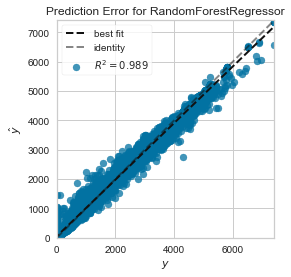

In [400]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

### Gradient Boosting Regressor <a name="regGBRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

Parameters
- *Loss*: Loss function
- *Learning_rate*: Learning rate shrinks the contribution of each tree by learning_rate
- *n_estimators*: The number of boosting stages to perform
- *Criterion*: The function to measure the quality of a split
- *n_iter_no_change*: used to decide if early stopping will be used to terminate training when validation score is not improving
- *validation_fraction*: The proportion of training data to set aside as validation set for early stopping

In [401]:
reg_gbr = GradientBoostingRegressor(loss="ls", learning_rate=0.05, n_estimators=300, criterion="friedman_mse", 
                                    random_state=42, n_iter_no_change=20, validation_fraction=0.1)

In [402]:
reg_gbr.fit(x_train_reg, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=20, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [403]:
reg_gbr_score = reg_gbr.score(x_test_reg, y_test_reg)

#Training
y_pred_gbr = reg_gbr.predict(x_test_reg)
reg_gbr_mse = mean_squared_error(y_pred_gbr, y_test_reg)

print("R^2 Score: ", reg_gbr_score)
print("MSE Test: ", reg_gbr_mse)
print("RMSE Test: ", np.sqrt(reg_gbr_mse))

R^2 Score:  0.8852262776654057
MSE Test:  181922.8305092388
RMSE Test:  426.5241265265528


In [404]:
for i in range(10):
    print("Predicted: ", y_pred_gbr[i], "Real: ", y_test_reg[i])

Predicted:  3525.734668580195 Real:  3669
Predicted:  2071.355636183348 Real:  1465
Predicted:  1738.5647625382564 Real:  1935
Predicted:  2110.1445470953595 Real:  2383
Predicted:  1726.1250000109294 Real:  1541
Predicted:  2352.668469958812 Real:  2360
Predicted:  1754.9420450457021 Real:  1536
Predicted:  2384.9019770797613 Real:  2402
Predicted:  1829.5810364193621 Real:  1409
Predicted:  2515.518997367078 Real:  2559


In [405]:
#Feature importance
importance = reg_gbr.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

weekday-6.08%
DamDepartures-7.24%
month_cos-7.51%
hour_cos-11.57%
hour_sin-50.00%


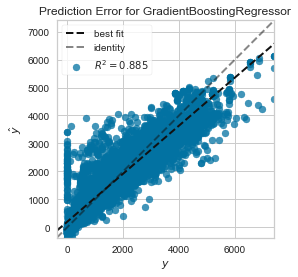

In [406]:
visualizer = PredictionError(reg_gbr)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

In [407]:
reg_en = LassoCV(n_jobs=5, random_state=42, selection="random")

In [408]:
reg_en.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=5, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='random', tol=0.0001,
    verbose=False)

In [409]:
reg_en_score=reg_en.score(x_test_reg, y_test_reg)

y_pred_las = reg_en.predict(x_test_reg)
reg_en_mse = mean_squared_error(y_pred_las, y_test_reg)

print("R^2 Sore: ", reg_en_score)
print("MSE: ", reg_en_mse)
print("RMSE: ", np.sqrt(reg_en_mse))

R^2 Sore:  0.4844971927101156
MSE:  817101.0570192816
RMSE:  903.9364231068918


In [410]:
for i in range(10):
    print("Predicted: ", y_pred_las[i], "Real: ", y_test_reg[i])

Predicted:  3282.7002152479454 Real:  3669
Predicted:  1220.7088283121143 Real:  1465
Predicted:  1427.9836401722246 Real:  1935
Predicted:  2190.822301479505 Real:  2383
Predicted:  2377.201701079988 Real:  1541
Predicted:  2377.201701079988 Real:  2360
Predicted:  3011.6092014717906 Real:  1536
Predicted:  3011.6092014717906 Real:  2402
Predicted:  2498.7387312279666 Real:  1409
Predicted:  2498.7387312279666 Real:  2559


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


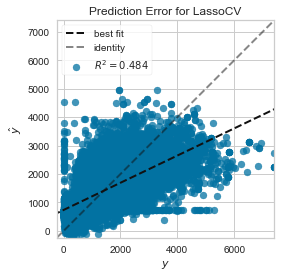

In [411]:
visualizer = PredictionError(reg_en)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

## Classification Models <a name="classification"></a>

In [412]:
classes = ["Level 1", "Level 2", "Level 3", "Level 4"]

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [413]:
#Check distribution crowdedness
clas_counts = TrainTest_df["CrowdednessCount"].values

#Normal Distribute values, give mu and std
clas_mu, clas_std = norm.fit(clas_counts)

In [414]:
clas_dict = TrainTest_df.to_dict("index")

for k, v in clas_dict.items():
    
    #Max crowdedness count for low level
    low_level = clas_mu - clas_std
    
    #Max crowdedness medium level
    high_level = clas_mu + clas_std
    
    #Assign class labels
    if v["CrowdednessCount"] < low_level:
        v["CrowdednessCount"] = 0
    elif v["CrowdednessCount"] >= high_level:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= low_level and v["CrowdednessCount"] < clas_mu:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= clas_mu and v["CrowdednessCount"] < high_level:
        v["CrowdednessCount"] = 2
        
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [415]:
clas_model_df.head()

,Date,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,NieuwezijdsLon,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2018-12-12,0.0,0.0,0.0,52.371942,4.901239,362.0,407.0,52.376288,4.893731,...,4.898903,52.373786,2018,0.866025,-0.5,0.017213,0.999852,-0.707107,-0.707107,3
1,2018-06-22,0.0,0.0,0.0,52.371942,4.901239,360.0,210.0,52.376288,4.893731,...,4.898903,52.373786,2018,-0.866025,-0.5,0.051620,0.998667,-0.258819,-0.965926,2
2,2018-09-30,0.0,0.0,0.0,52.371942,4.901239,348.0,235.0,52.376288,4.893731,...,4.898903,52.373786,2018,-0.866025,0.5,0.478734,0.877960,-0.258819,-0.965926,2
3,2018-05-31,0.0,0.0,0.0,52.371942,4.901239,372.0,258.0,52.376288,4.893731,...,4.898903,52.373786,2018,-0.866025,0.5,0.478734,0.877960,-0.500000,-0.866025,2
4,2018-12-06,0.0,0.0,0.0,52.371942,4.901239,398.0,392.0,52.376288,4.893731,...,4.897334,52.372524,2018,-0.866025,0.5,0.478734,0.877960,-0.866025,-0.500000,2


In [429]:
train_df_clas = clas_model_df[class_model_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date", "index"])

test_df_clas = clas_model_df[class_model_df["Date"].isin(test_set_dates)].reset_index().drop(columns=["Date", "index"])

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [430]:
train_df_clas.head()

,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,NieuwezijdsLon,NieuwezijdsArrivals,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,0.0,0.0,0.0,52.371942,4.901239,348.0,235.0,52.376288,4.893731,171.0,...,4.898903,52.373786,2018,-0.866025,0.5,0.478734,0.87796,-0.258819,-0.965926,2
1,0.0,0.0,0.0,52.371942,4.901239,398.0,392.0,52.376288,4.893731,203.0,...,4.897334,52.372524,2018,-0.866025,0.5,0.478734,0.87796,-0.866025,-0.500000,2
2,0.0,0.0,0.0,52.371942,4.901239,398.0,392.0,52.376288,4.893731,203.0,...,4.898903,52.373786,2018,-0.866025,0.5,0.478734,0.87796,-0.866025,-0.500000,2
3,0.0,0.0,0.0,52.371942,4.901239,469.0,473.0,52.376288,4.893731,237.0,...,4.898903,52.373786,2018,-0.866025,0.5,0.478734,0.87796,-0.965926,-0.258819,2
4,0.0,0.0,0.0,52.371942,4.901239,283.0,296.0,52.376288,4.893731,143.0,...,4.897334,52.372524,2018,-0.866025,0.5,0.478734,0.87796,-0.965926,0.258819,1


In [431]:
#Train
x_train_clas = train_df_clas.drop(["CrowdednessCount"], axis=1)
y_train_clas = train_df_clas["CrowdednessCount"]

#Test
x_test_clas = test_df_clas.drop(["CrowdednessCount"], axis=1)
y_test_clas = test_df_clas["CrowdednessCount"]

feature_labels_clas = train_df_clas.columns.values

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

In [432]:
clas_bas = DummyClassifier(strategy="most_frequent", random_state=42)

In [433]:
clas_bas.fit(x_train_clas, y_train_clas)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

In [434]:
y_pred_clas_bas = clas_bas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_bas))
print(classification_report(y_test_clas, y_pred_clas_bas))

Accuracy Score:  0.3861750183842841
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1723
           1       0.39      1.00      0.56      3676
           2       0.00      0.00      0.00      2515
           3       0.00      0.00      0.00      1605

   micro avg       0.39      0.39      0.39      9519
   macro avg       0.10      0.25      0.14      9519
weighted avg       0.15      0.39      0.22      9519



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


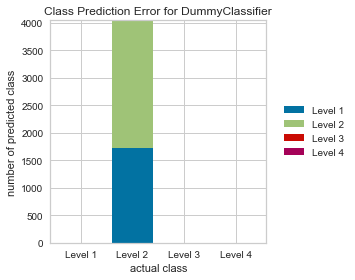

In [435]:
visualizer = ClassPredictionError(
    clas_bas, classes=classes
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [436]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=20, random_state=42, 
                                  class_weight="balanced")

In [437]:
clas_rfc.fit(x_train_clas, y_train_clas)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=20, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [438]:
y_pred_rfc = clas_rfc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_rfc))
print(classification_report(y_test_clas, y_pred_rfc))

Accuracy Score:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00      3676
           2       1.00      1.00      1.00      2515
           3       1.00      1.00      1.00      1605

   micro avg       1.00      1.00      1.00      9519
   macro avg       1.00      1.00      1.00      9519
weighted avg       1.00      1.00      1.00      9519



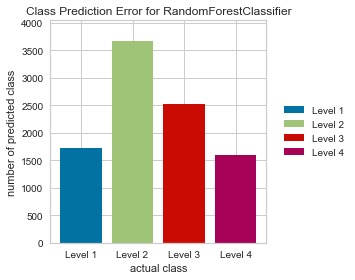

In [439]:
visualizer = ClassPredictionError(
    clas_rfc, classes=classes
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

### Gradient Boosting Classifier <a name="classGBCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [440]:
clas_gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, random_state=42, n_iter_no_change=20, 
                                     validation_fraction=0.1)

In [441]:
clas_gbc.fit(x_train_clas, y_train_clas)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=20, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [442]:
y_pred_gbc = clas_gbc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_gbc))
print(classification_report(y_test_clas, y_pred_gbc))

Accuracy Score:  0.8579682739783591
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1723
           1       0.88      0.87      0.88      3676
           2       0.78      0.83      0.80      2515
           3       0.87      0.82      0.85      1605

   micro avg       0.86      0.86      0.86      9519
   macro avg       0.86      0.86      0.86      9519
weighted avg       0.86      0.86      0.86      9519



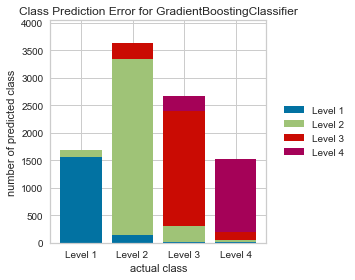

In [443]:
visualizer = ClassPredictionError(
    clas_gbc, classes=classes
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

### SGD Classifier  <a name="classSGDModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [444]:
reg_sgd = SGDClassifier(n_jobs=50, random_state=42)

In [445]:
reg_sgd.fit(x_train_clas, y_train_clas)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=50, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [446]:
y_pred_sgd = reg_sgd.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_sgd))
print(classification_report(y_test_clas, y_pred_sgd))

Accuracy Score:  0.4301922470847778
              precision    recall  f1-score   support

           0       0.43      0.96      0.59      1723
           1       0.76      0.23      0.35      3676
           2       0.49      0.03      0.06      2515
           3       0.35      0.94      0.51      1605

   micro avg       0.43      0.43      0.43      9519
   macro avg       0.51      0.54      0.38      9519
weighted avg       0.56      0.43      0.35      9519



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


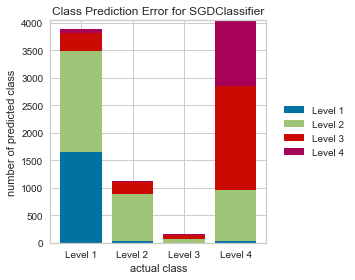

In [447]:
visualizer = ClassPredictionError(
    reg_sgd, classes=classes
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

### Voting Classifier <a name="classVCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)

This classifier combines the classifications of the [Random Forrest Classification](#classRFCModel) and [Gradient Boosting Classification](#classGBCModel) by classifying each instance with the one of the classes given by the models. 

In [448]:
#List estimator models
estimators = [("rfc", clas_rfc), ("gbc", clas_gbc)]

clas_vc = VotingClassifier(estimators=estimators, voting="soft", n_jobs=20,weights=[1, 1])

In [449]:
clas_vc.fit(x_train_clas, y_train_clas)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=20, voting='soft', weights=[1, 1])

In [450]:
y_pred_vc = clas_vc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_vc))
print(classification_report(y_test_clas, y_pred_vc))

Accuracy Score:  0.9700598802395209
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1723
           1       0.98      0.97      0.97      3676
           2       0.96      0.97      0.97      2515
           3       0.96      0.98      0.97      1605

   micro avg       0.97      0.97      0.97      9519
   macro avg       0.97      0.97      0.97      9519
weighted avg       0.97      0.97      0.97      9519

